# Part 0: Set up environment and load data

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.arima_model import ARMA

import itertools
import warnings
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Data could be downloaded from Yahoo.com

In [3]:
link = 'https://drive.google.com/open?id=1wdf3FfKdR_xNh2rJeYWL4ye0_FUZ9WM7'


fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('MSFT_Stock.csv') 
#read in data, take date as the index
microsoft  = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
microsoft.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
len(microsoft)

1511

In [5]:
TS_Monthly_df   = pd.read_csv('MSFT_Stock.csv')
TS_df = microsoft

# Part 1: Data Exploration

# Part 1.1 Raw Dataset

In [6]:
TS_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [7]:
TS_df.nunique()

Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

In [8]:
TS_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# Part 1.2 EDA

Text(0.5, 1.0, 'MSFT stock attributes from 2015 to 2021')

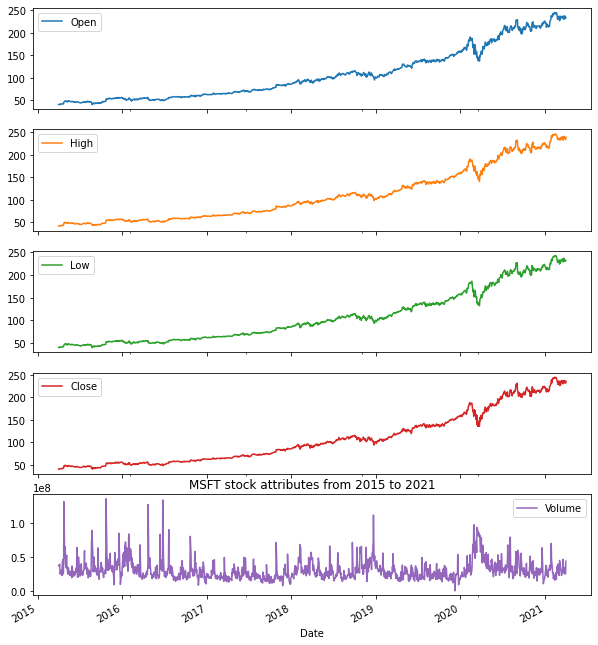

In [9]:
TS_df['2015':'2021'].plot(subplots=True, figsize=(10,12))
plt.title('MSFT stock attributes from 2015 to 2021')

There's an upward trend of open, high, low, close price.

Text(0.5, 1.0, 'Changes over time')

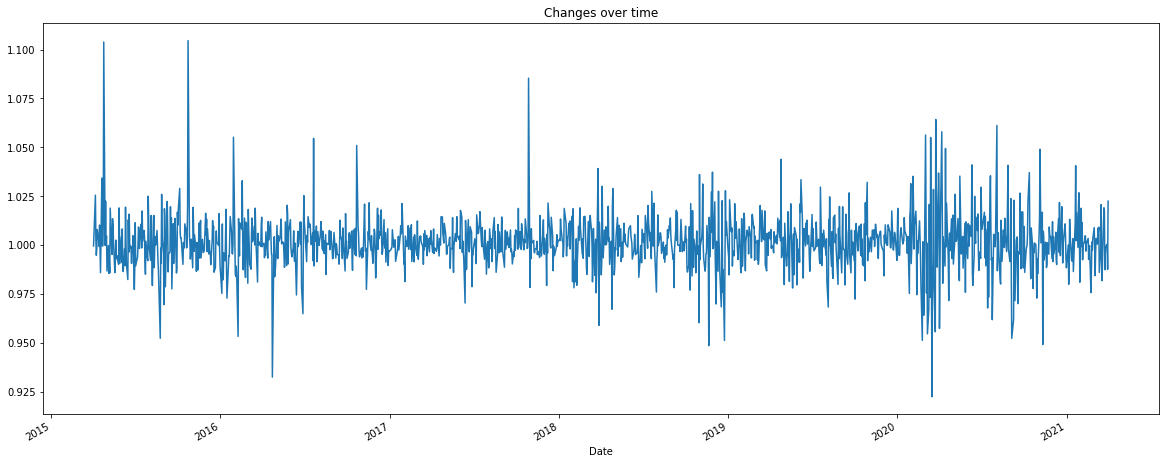

In [10]:
#shift the high price by one day
TS_df['Change'] = TS_df.High.div(TS_df.High.shift())
TS_df['Change'].plot(figsize=(20,8))
plt.title("Changes over time")

"Return on investment (ROI) is an approximate measure of an investment's profitability.ROI is calculated by subtracting the initial value of the investment from the final value of the investment (which equals the net return), then dividing this new number (the net return) by the cost of the investment, then finally, multiplying it by 100."

Text(0.5, 1.0, 'ROI over time')

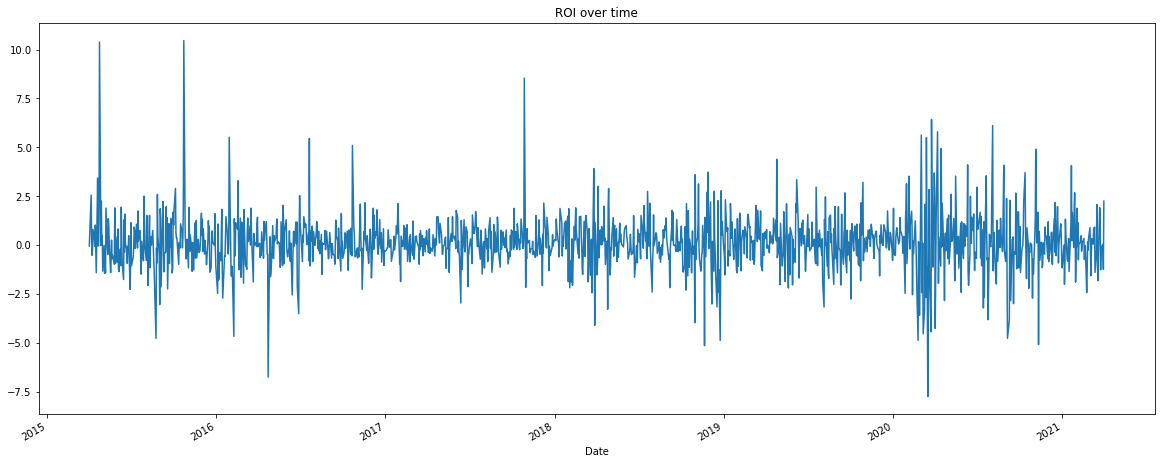

In [11]:
TS_df['Return'] = TS_df.Change.sub(1).mul(100)
TS_df['Return'].plot(figsize=(20,8))
plt.title("ROI over time")

Apply window functions

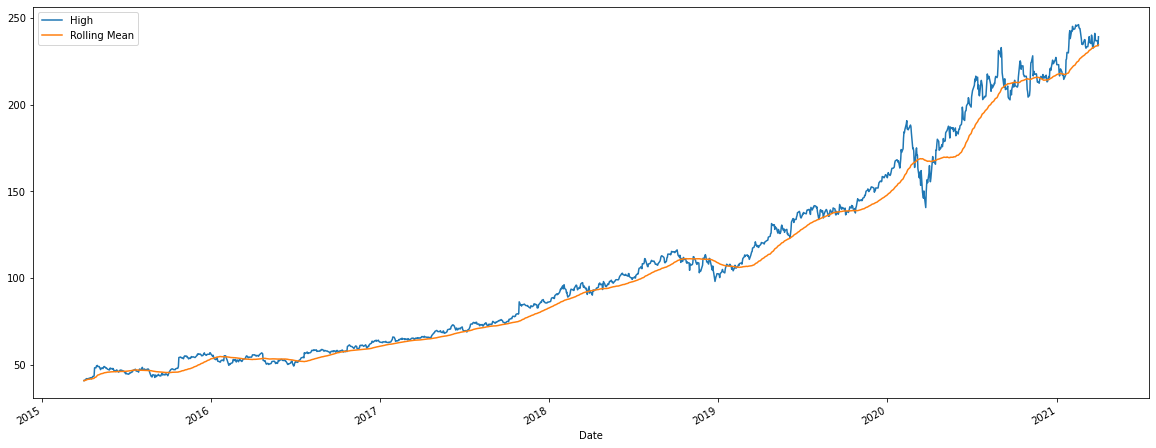

In [12]:
rolling_MSFT = TS_df.High.rolling('90D').mean() #mean of high price within 90 days
# rolling_MSFT
TS_df.High.plot(figsize=(20,8))
rolling_MSFT.plot()

plt.legend(['High','Rolling Mean'])

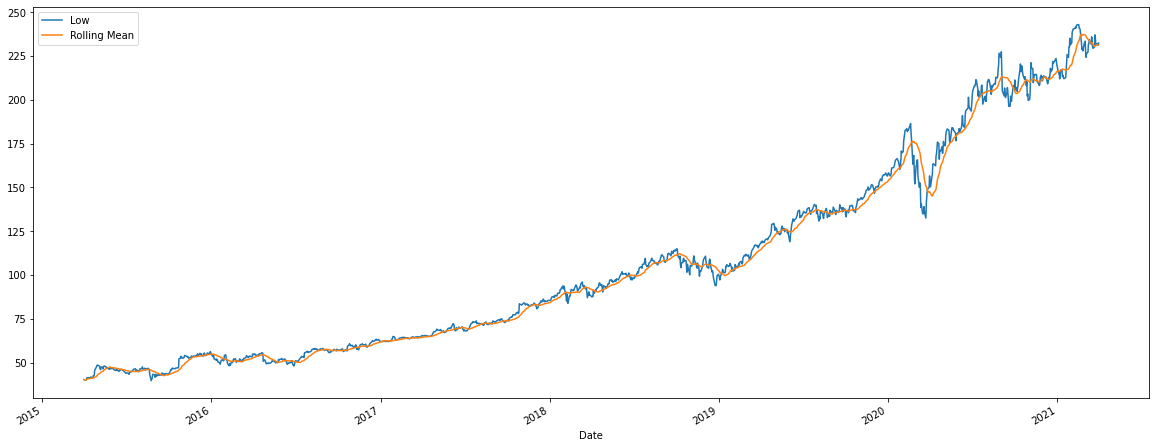

In [13]:
rolling_MSFT_low = TS_df.Low.rolling('30D').mean() #mean of low price within 90 days
TS_df.Low.plot(figsize=(20,8))
rolling_MSFT_low.plot()

plt.legend(['Low','Rolling Mean'])

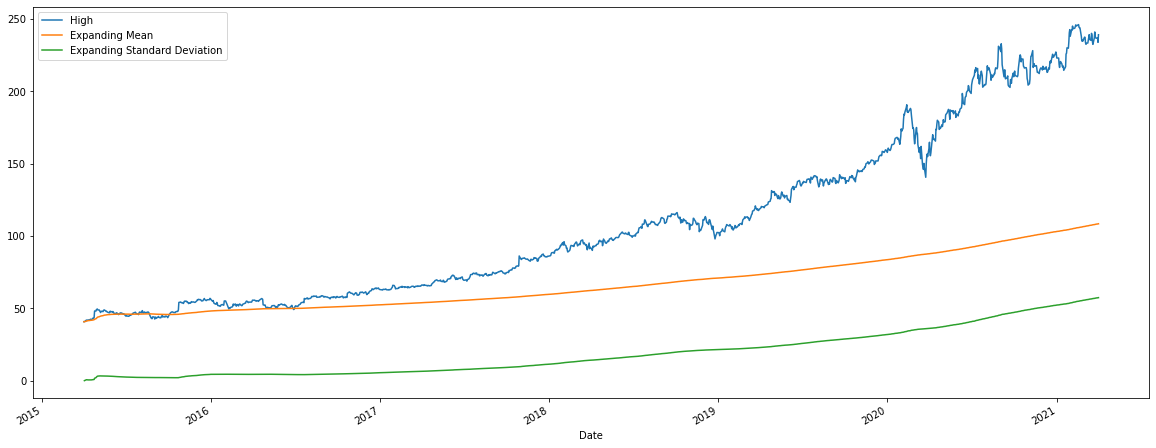

In [14]:
microsoft_mean = TS_df.High.expanding().mean()
microsoft_std = TS_df.High.expanding().std()
TS_df.High.plot(figsize=(20,8))
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])

Check acf and pacf plots

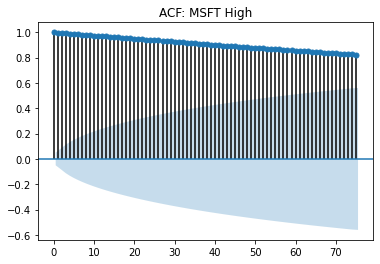

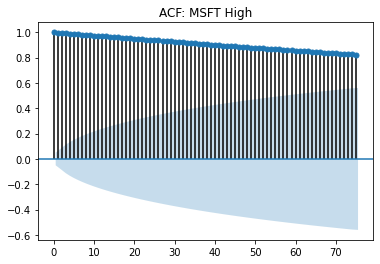

In [15]:
plot_acf(TS_df.High,lags=75,title="ACF: MSFT High")

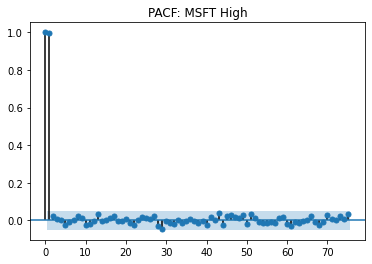

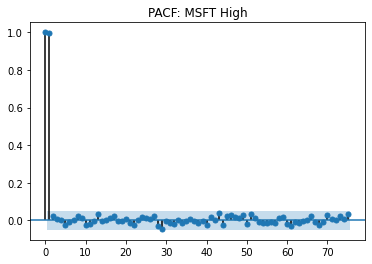

In [16]:
plot_pacf(TS_df.High,lags=75,title="PACF: MSFT High")

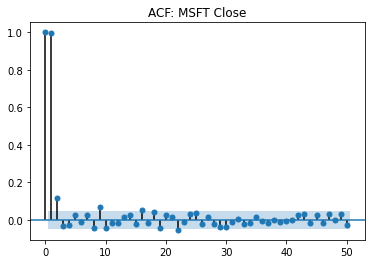

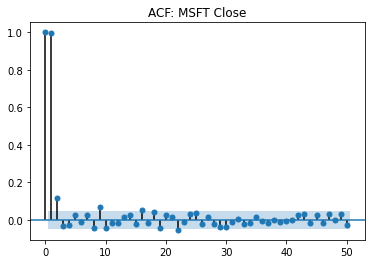

In [17]:
plot_pacf(TS_df["Close"],lags=50,title="ACF: MSFT Close")

In [18]:
TS_Monthly_df['dateN']=pd.to_datetime(TS_Monthly_df['Date'])
TS_Monthly_df.set_index('dateN',inplace=True)
TS_Monthly_df.head()

,Date,Open,High,Low,Close,Volume
dateN,,,,,,
2015-04-01 16:00:00,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


plot the mean of each year's close price

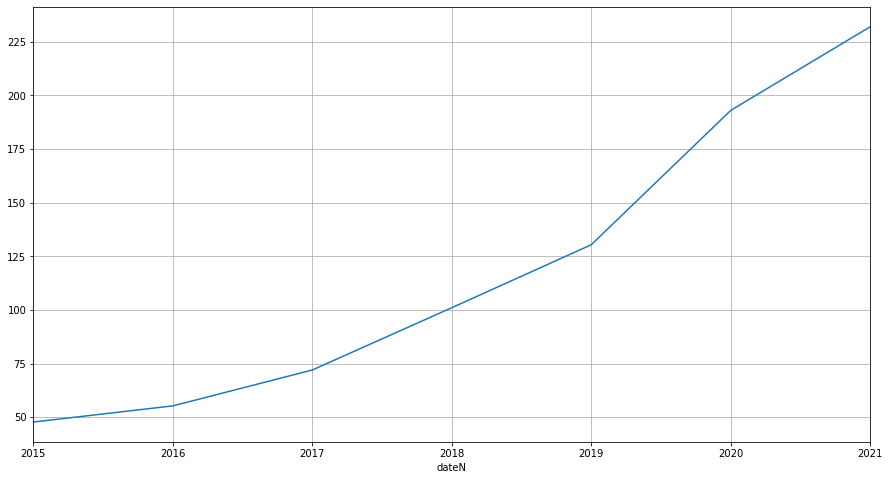

In [19]:
TS_Monthly_df['Close'].resample('Y').mean().plot(figsize=(15,8), grid = True)

In [20]:
TS_Monthly_df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


# Part 2: Data Cleaning and Feature Preprocessing

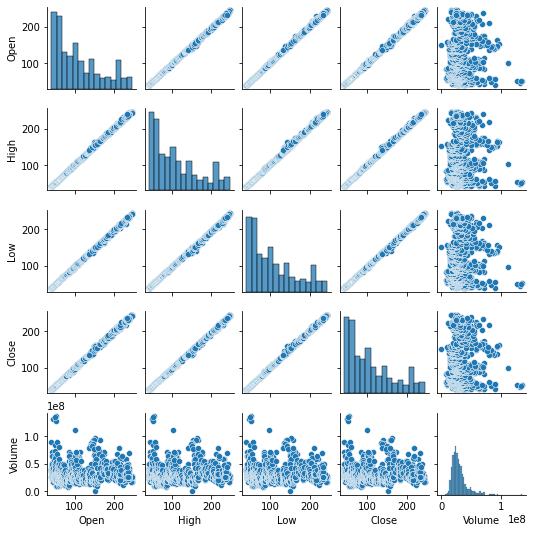

In [21]:
sns.pairplot(data=TS_Monthly_df, height=1.5)

Open, High, Low, Close have positive relationships between each two.

Conduct a seasonal decomposition on close price by yearly frequence, to get rid of trend and seasonality.

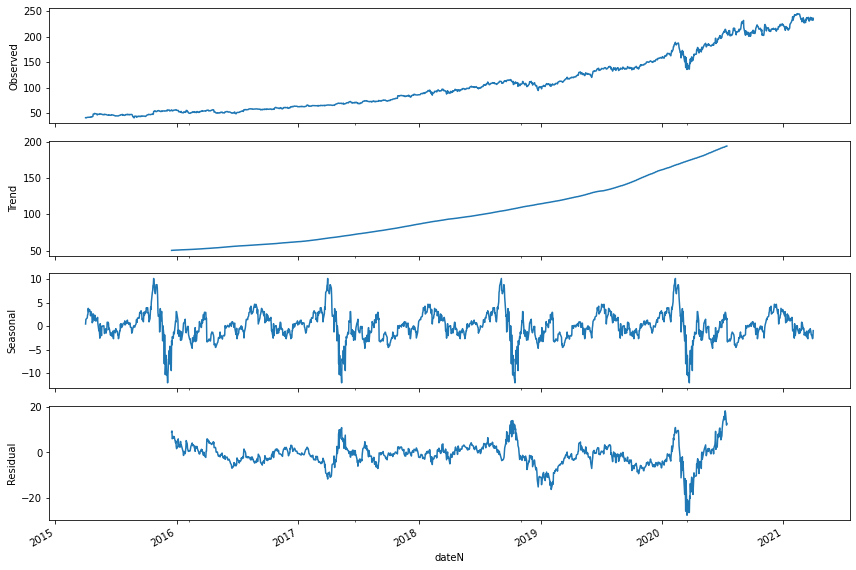

In [22]:
rcParams['figure.figsize'] = 12, 8
pred_df_sim1_new = sm.tsa.seasonal_decompose(TS_Monthly_df.Close, model='additive', freq=360)
pred_df_sim2_full = TS_Monthly_df.Close
figure = pred_df_sim1_new.plot()
plt.show()

Get rid of missing value

In [23]:
len(pred_df_sim1_new.resid)
#pred_df_sim1_new.resid.isnull().sum() #360

1511

In [24]:
sim1=pred_df_sim1_new.resid.dropna()
sim2 = pred_df_sim2_full.dropna()

# Part 3: Modeling

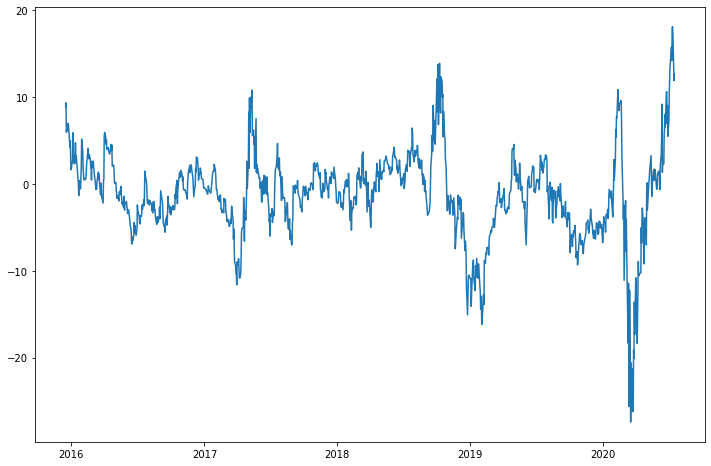

In [25]:
plt.plot(sim1)

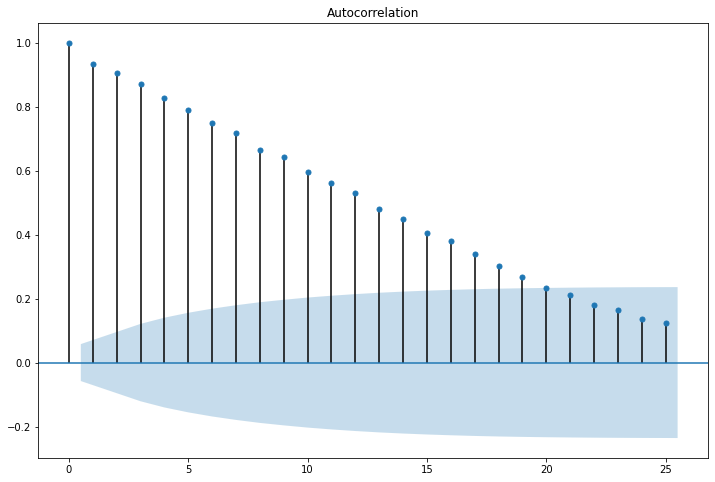

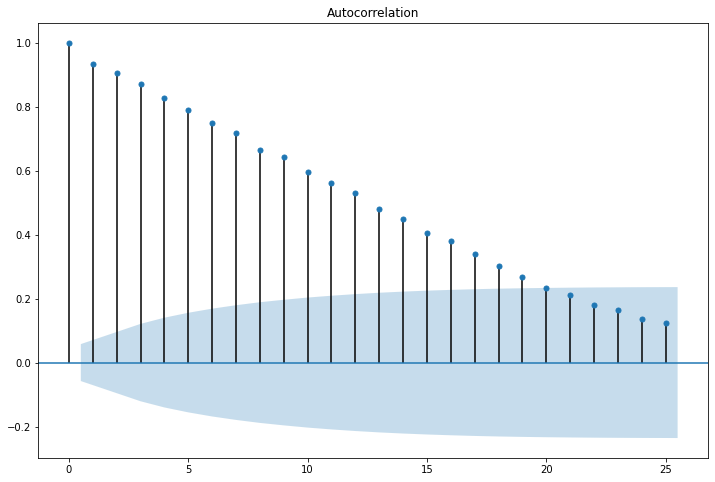

In [26]:
plot_acf(sim1, lags = 25)

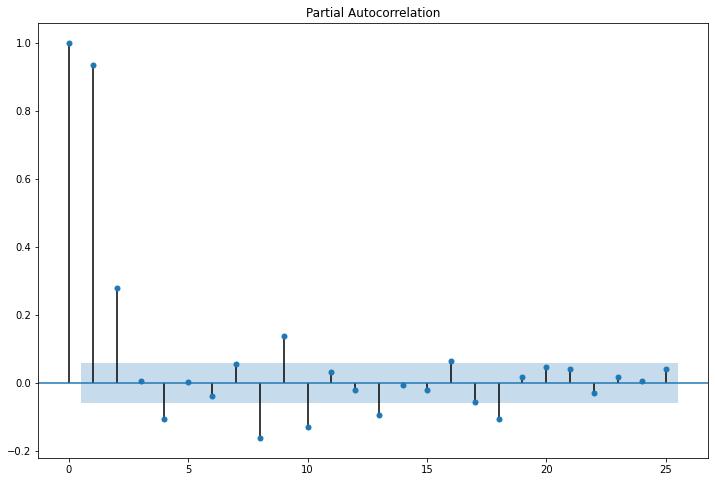

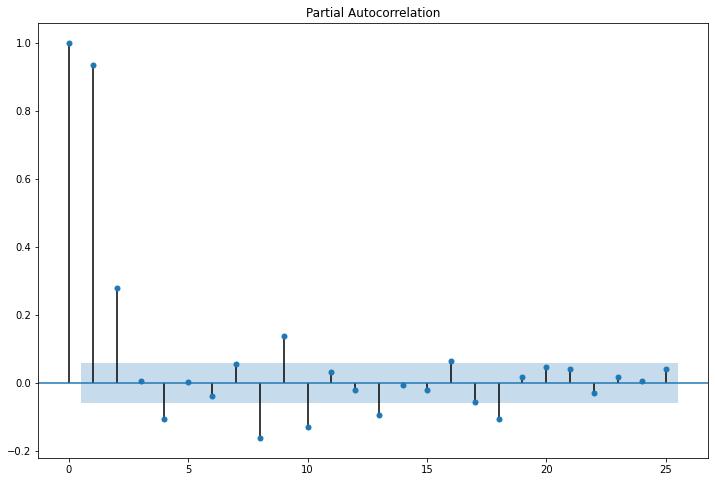

In [27]:
plot_pacf(sim1, lags=25)

PACF截尾，ACF拖尾：AR模型；从PACF可以看出p=2.

In [28]:
#fit an AR(2) model
model = ARMA(sim1, order=(2,0))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


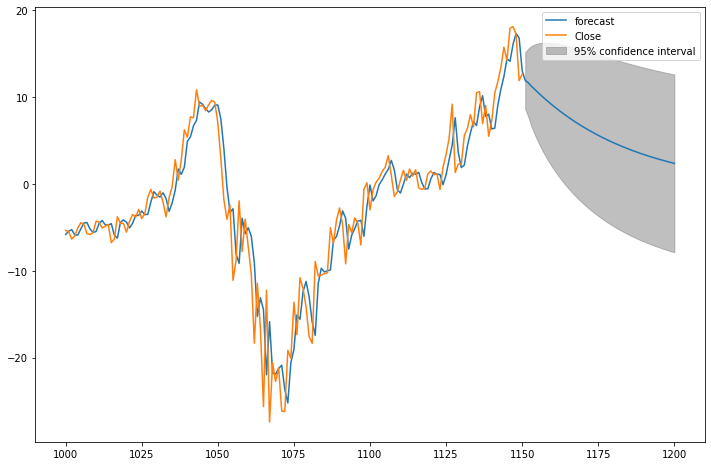

In [29]:
# Predicting simulated AR(2) model 
result.plot_predict(start=1000, end=1200) #Plot forecasts
plt.show()

The forecast line stayed close to the 'Close' price

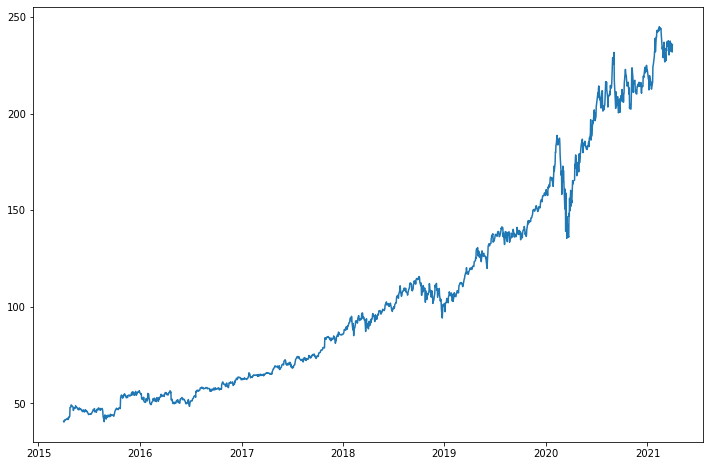

In [30]:
plt.plot(sim2)

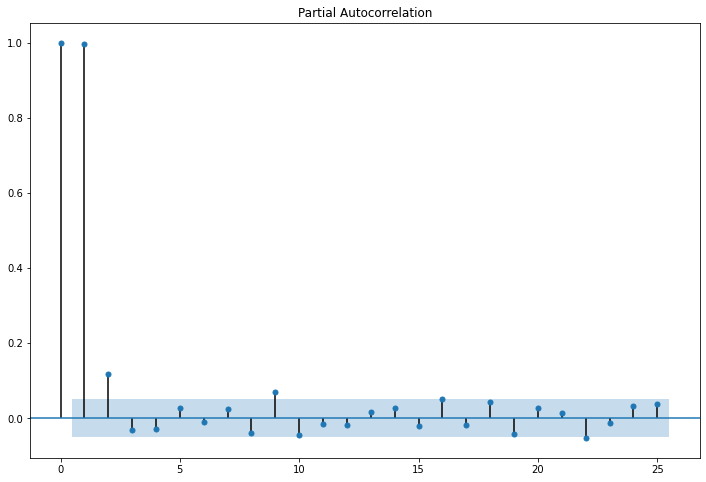

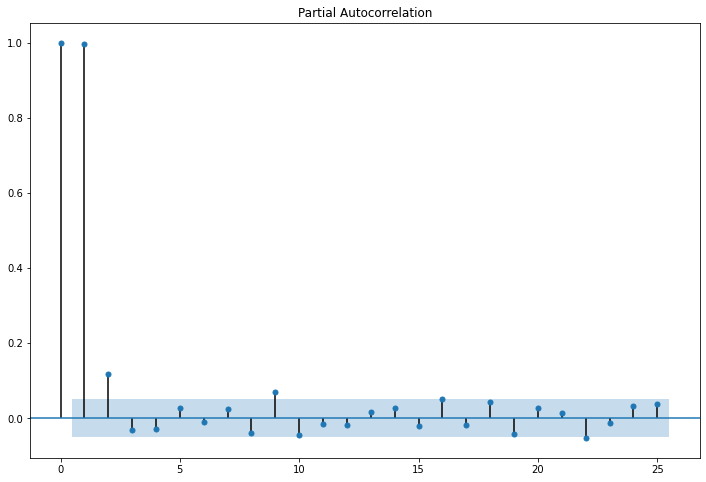

In [31]:
plot_pacf(sim2, lags=25)

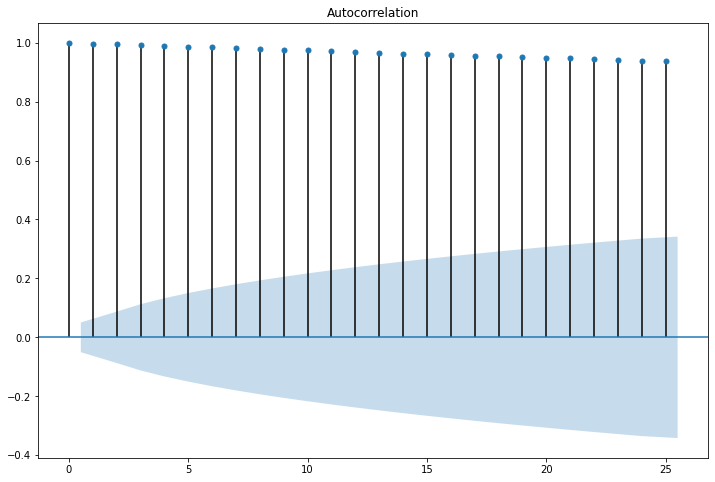

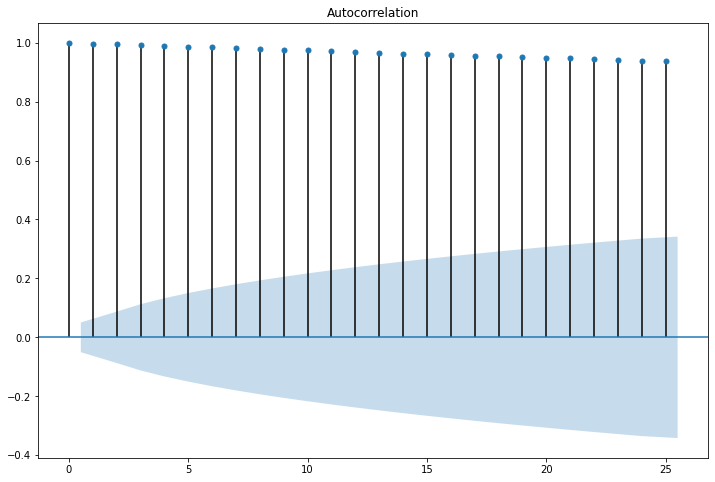

In [32]:
plot_acf(sim2, lags=25)

In [33]:
model_s = sm.tsa.statespace.SARIMAX(sim2, order=(2, 3, 3),)
MSFTresults = model_s.fit()
print(MSFTresults.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2739      0.014    -93.913      0.000      -1.300      -1.247
ar.L2         -0.2756      0.010    -28.467      0.000      -0.295      -0.257
ma.L1         -0.9969      0.194     -5.149      0.000      -1.376      -0.617
ma.L2         -0.9999      0.386     -2.588      0.010      -1.757      -0.243
ma.L3          0.9968      0.193      5.166      0.000       0.619       1.375
sigma2         5.1430      0.946      5.436      0.000       3.289       6.997


In [34]:
MSFTresults.aic

6782.356564439854

In [35]:
MSFTresults.bic

6814.267801731262

In [36]:
# model_s = sm.tsa.statespace.SARIMAX(sim2, order=(2, 3, 2),)
# MSFTresults = model_s.fit()
# MSFTresults.aic, MSFTresults.aic

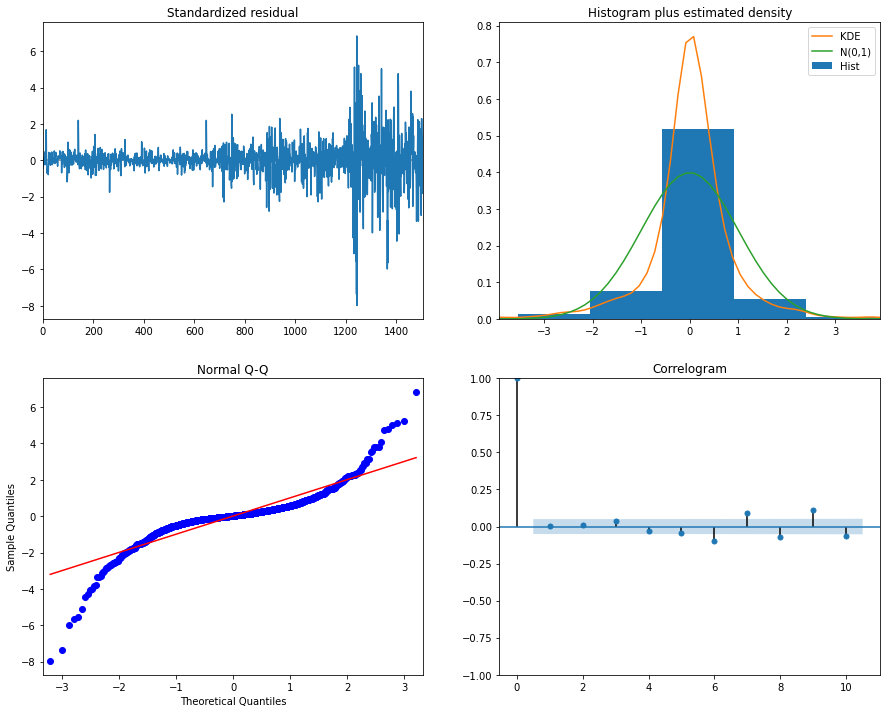

In [37]:
MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
print(acorr_ljungbox(MSFTresults.resid, lags=6))

(array([50.66277686, 54.63603046, 55.21055957, 56.14009268, 57.84783489,
       64.57148204]), array([1.09680103e-12, 1.36752958e-12, 6.19146244e-12, 1.87404274e-11,
       3.38122173e-11, 5.27665989e-12]))


<0.05:not white noise

In [39]:
pred = MSFTresults.get_prediction(start=1400, dynamic=False)

dynamic=False参数确保我们每个点的预测将使用之前的所有历史观测。

In [40]:
pred_ci = pred.conf_int() #Returns the confidence interval of the fitted parameters. 
pred_ci

,lower Close,upper Close
dateN,,
2020-10-21 16:00:00,210.444469,219.336598
2020-10-22 16:00:00,210.684671,219.576799
2020-10-23 16:00:00,210.778006,219.670130
2020-10-26 16:00:00,211.791749,220.683873
2020-10-27 16:00:00,207.662210,216.554329
...,...,...
2021-03-25 16:00:00,231.991145,240.883018
2021-03-26 16:00:00,229.080594,237.972468
2021-03-29 16:00:00,231.292094,240.183963


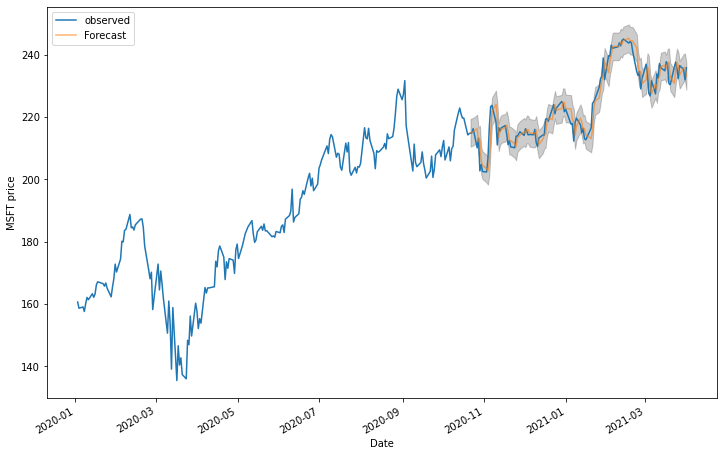

In [41]:
ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()

# Part 4: Model Evaluation & Tuning parameters

In [42]:
y_forecasted = pred.predicted_mean
y_truth1 = TS_df.Close['2020-10-21 16:00:00':]

In [43]:
# Compute the mean square error
mse = ((y_forecasted - y_truth1) ** 2).mean()
print('The Mean Squared Error of our forecast 1 is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecast 1 is 12.8


Use AIC&BIC to choose the best parameters

In [44]:
p_min=0
d_min=0
q_min=0
p_max=4
d_max=4
q_max=4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# get the results of different combination of p,d,q
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue 
    try:
        model = sm.tsa.SARIMAX(sim2, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit() 
## print(model_results.summary())
## print(model_results.summary().tables[1])
        # print("results.bic",results.bic)
        # print("results.aic",results.aic)
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

In [45]:
results_bic

,MA0,MA1,MA2,MA3,MA4
AR0,11945.429849,10079.143693,8314.554687,6951.952223,6890.047378
AR1,10433.187927,8877.503402,7538.021441,6857.642363,6993.608345
AR2,9557.634952,8263.163274,7258.946861,6947.507030,6861.687751
AR3,9084.986716,7960.211770,7840.806028,7269.507393,6870.099061
AR4,8568.162696,7705.398067,7118.696819,7180.013914,7243.720247


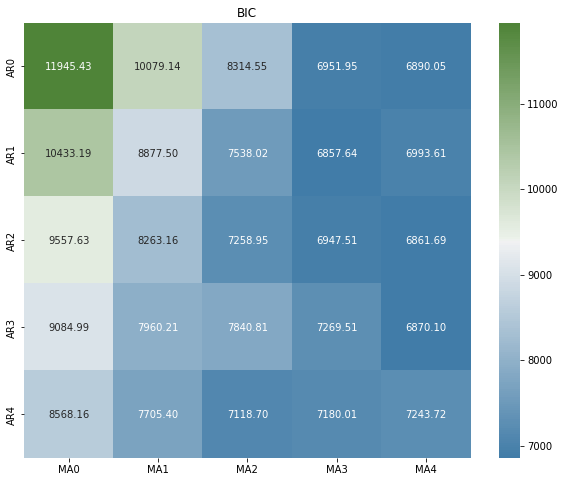

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 cmap=sns.diverging_palette(6000, 12000, n=200),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

ARMA(1,,3) gives the lowest BIC.

In [47]:
# Initialize a DataFrame to store the results
results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# get the results of different combination of p,d,q
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue 
    try:
        model = sm.tsa.SARIMAX(sim2, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit() 
## print(model_results.summary())
## print(model_results.summary().tables[1])
        # print("results.bic",results.bic)
        # print("results.aic",results.aic)
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
    except:
        continue
results_aic = results_aic[results_aic.columns].astype(float)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

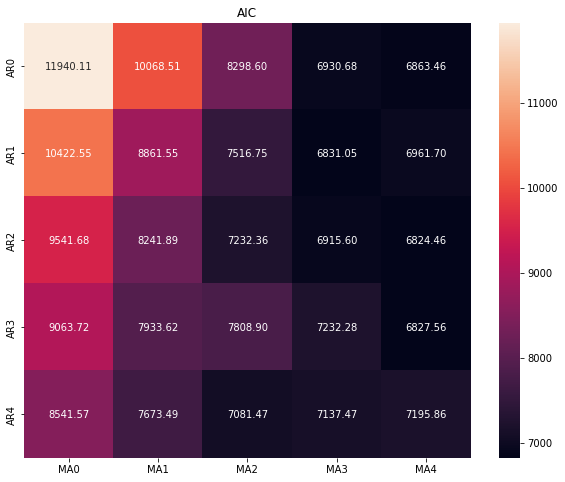

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_aic,
                 mask=results_aic.isnull(),
                 #cmap=sns.diverging_palette(6000, 12000, n=200),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('AIC');

ARMA(3,,4) gives the smallest aic.

Try modelling ARMA(1,3,3)

In [49]:
model1 = sm.tsa.statespace.SARIMAX(sim2, order=(1, 3, 3),)
result1 = model1.fit()
print(result1.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9940      0.004   -241.495      0.000      -1.002      -0.986
ma.L1         -0.9991      0.171     -5.840      0.000      -1.334      -0.664
ma.L2         -1.0000      0.340     -2.938      0.003      -1.667      -0.333
ma.L3          0.9991      0.170      5.872      0.000       0.666       1.333
sigma2         5.5415      0.937      5.915      0.000       3.705       7.378


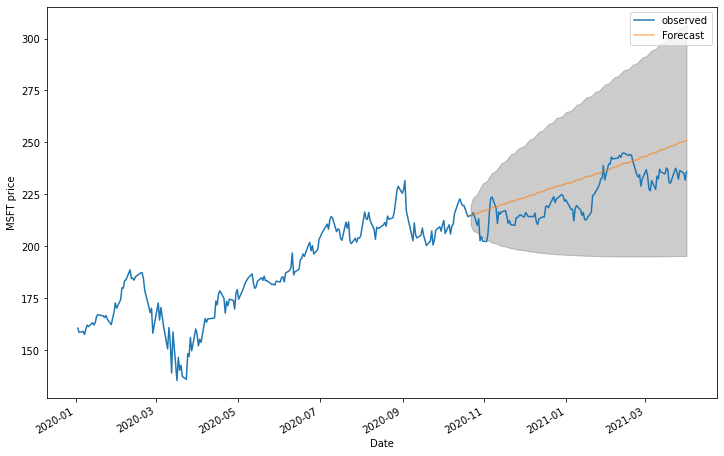

In [50]:
pred1 = result1.get_prediction(start=1400, dynamic=True)
pred1_ci = pred1.conf_int()
ax = sim2['2020':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)
ax.fill_between(pred1_ci.index, pred1_ci.iloc[:, 0], pred1_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()

In [51]:
y_forecasted1 = pred1.predicted_mean
mse = ((y_forecasted1 - y_truth1) ** 2).mean()
mse

110.52439405166038

ARMA(3,3,4)

In [52]:
model2 = sm.tsa.statespace.SARIMAX(sim2, order=(3, 3, 4),)
result2 = model2.fit()
print(result2.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2304      0.010   -217.519      0.000      -2.251      -2.210
ar.L2         -1.5386      0.019    -79.499      0.000      -1.577      -1.501
ar.L3         -0.2807      0.010    -28.272      0.000      -0.300      -0.261
ma.L1         -0.0346      0.009     -3.902      0.000      -0.052      -0.017
ma.L2         -1.9233      0.009   -218.187      0.000      -1.941      -1.906
ma.L3         -0.0382      0.009     -4.190      0.000      -0.056      -0.020
ma.L4          0.9962      0.009    109.728      0.000       0.978       1.014
sigma2         5.0820      0.093     54.425      0.000       4.899       5.265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


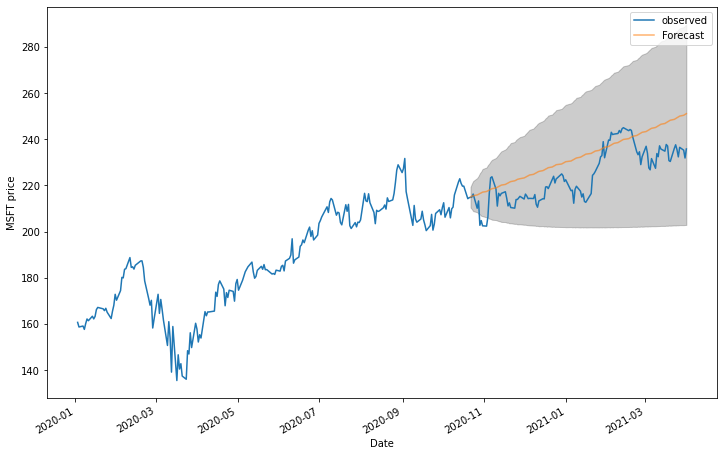

In [53]:
pred2 = result2.get_prediction(start=1400, dynamic=True)
pred2_ci = pred2.conf_int()
ax = sim2['2020':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()

In [54]:
y_forecasted2 = pred2.predicted_mean
mse = ((y_forecasted2 - y_truth1) ** 2).mean()
mse

78.24950793106625

# Part 5: Improvement

Use LSTM

# Part 5.1: Data Preprocessing

In [55]:
MSFT_df = pd.read_csv('MSFT_Stock.csv')

In [56]:
MSFT_df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


Split training and testing set

In [57]:
train = MSFT_df.iloc[:1000, 4:5].values
test = MSFT_df.iloc[1000:, 4:5].values

In [58]:
train.shape, test.shape

((1000, 1), (511, 1))

Normalization: scale the feature into range (0,1)

In [59]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

In [60]:
train_scaled.shape

(1000, 1)

Separate training set into training data and labels: 60 time-steps corresponding to 1 output

In [61]:
x_train, y_train = [], []
for i in range(60,1000):
  x_train.append(train_scaled[i-60:i, 0])
  y_train.append(train_scaled[i, 0])

In [62]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [63]:
x_train.shape, y_train.shape

((940, 60), (940,))

In [64]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Part 5.2: Modeling 

build LSTM with 50 neurons and 4 hidden layers

In [65]:
model = Sequential()
#setting return sequences to True to access the hidden state output for each input time step.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [66]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 9s 97ms/step - loss: 0.1217
Epoch 2/100
30/30 [==============================] - 3s 97ms/step - loss: 0.0850
Epoch 3/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0831
Epoch 4/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0818
Epoch 5/100
30/30 [==============================] - 3s 99ms/step - loss: 0.0815
Epoch 6/100
30/30 [==============================] - 3s 96ms/step - loss: 0.0812
Epoch 7/100
30/30 [==============================] - 3s 99ms/step - loss: 0.0808
Epoch 8/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0796
Epoch 9/100
30/30 [==============================] - 3s 100ms/step - loss: 0.0796
Epoch 10/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0795
Epoch 11/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0786
Epoch 12/100
30/30 [==============================] - 3s 96ms/step - loss: 0.0788
Epoch 13/100
30/30 [====

Prepare testing set

In [86]:
test_scaled = scaler.fit_transform(test)
test_scaled.shape

(511, 1)

In [82]:
# dataset_train = MSFT_df.iloc[:1000, 4:5]
# dataset_test = MSFT_df.iloc[1000:, 4:5]
# dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
# dataset_total

In [83]:
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# inputs = inputs.reshape(-1,1)
# inputs = scaler.transform(inputs)
# inputs[:10]

In [84]:
# x_test = []
# for i in range(60, 571):
#     x_test.append(inputs[i-60:i, 0])
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# x_test.shape

In [ ]:
#test = test.reshape(-1, 1)
# test_scaled = scaler.fit_transform(test)
# test_scaled.shape

In [ ]:
# test_scaled[:10]

In [ ]:
# x_test = []
# for i in range(60, 511):
#   x_test.append(test_scaled[i-60:i, 0])

In [ ]:
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# x_test.shape

Make predictions using the test set

In [122]:
y_pred = model.predict(test_scaled)
y_pred.shape

(511, 1, 1)

In [124]:
y_pred[:5]

array([[[0.4128948 ]],

       [[0.41292536]],

       [[0.41293788]],

       [[0.41288072]],

       [[0.41288877]]], dtype=float32)

In [111]:
y_pred = y_pred.reshape((-1,1))
y_pred.shape

(511, 1)

In [120]:
y_pred[:5]

array([[[0.4128948 ]],

       [[0.41292536]],

       [[0.41293788]],

       [[0.41288072]],

       [[0.41288877]]], dtype=float32)

In [112]:
predicted_close_price = scaler.inverse_transform(y_pred)

In [113]:
predicted_close_price.shape

(511, 1)

In [125]:
predicted_close_price[:5]

array([[169.71136],
       [169.71529],
       [169.71689],
       [169.70956],
       [169.71059]], dtype=float32)

Visualize the results

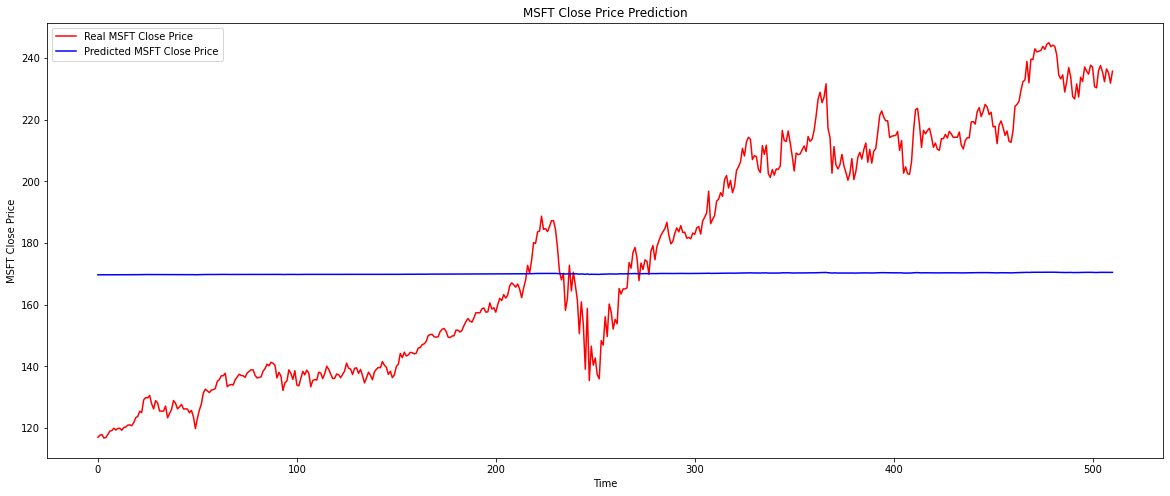

In [116]:
plt.figure(figsize=(20, 8))
plt.plot(test, color = 'red', label = 'Real MSFT Close Price')
plt.plot(predicted_close_price, color = 'blue', label = 'Predicted MSFT Close Price')
plt.xticks(np.arange(0,510,100))
plt.title('MSFT Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Close Price')
plt.legend()
plt.show()